In [2]:
import sys, os
sys.path.append(os.path.abspath("/Users/DavidHolzwarth/Uni/EPFL/bachelors-thesis"))

import time
import matplotlib.pyplot as plt

import LE as le
import LP as lp
import iterative as iterative
import logger_creator

import graph_tools
import graph_viz as viz
import networkx as nx
import numpy as np
import pandas as pd
import random

/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/dash_bootstrap_components/_table.py:5: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [ ]:
import importlib
importlib.reload(viz)

<module 'graph_viz' from '/Users/DavidHolzwarth/Uni/EPFL/bachelors-thesis/graph_viz.py'>

: 

In [3]:
def generate_rmat_edge(N, A, B, C, D):
    """
    Recursively generate a single edge based on R-MAT quadrant probabilities.
    """
    src, dst = 0, 0
    step = N // 2
    while step > 0:
        p = random.random()
        if p < A:
            pass  # top-left quadrant
        elif p < A + B:
            dst += step  # top-right
        elif p < A + B + C:
            src += step  # bottom-left
        else:
            src += step
            dst += step  # bottom-right
        step //= 2
    return src, dst

def generate_rmat_multidigraph(N, M, A=0.45, B=0.15, C=0.15, D=0.25, seed=None):
    if seed is not None:
        random.seed(seed)

    G = nx.MultiDiGraph()
    G.add_nodes_from(range(N))

    for _ in range(M):
        src, dst = generate_rmat_edge(N, A, B, C, D)
        G.add_edge(src, dst)

    return G

def collapse_multiedges_to_weighted_digraph(multi_graph: nx.MultiDiGraph) -> nx.DiGraph:
    """
    Convert a MultiDiGraph to a DiGraph, summing the count of parallel edges
    into a 'weight' attribute for each edge.
    """
    digraph = nx.DiGraph()

    # Add nodes to the new graph (copy all node attributes)
    digraph.add_nodes_from(multi_graph.nodes(data=True))

    # Count edges and assign weight
    for u, v in multi_graph.edges():
        if digraph.has_edge(u, v):
            digraph[u][v]['weight'] += 1
        else:
            digraph.add_edge(u, v, weight=1)

    return digraph

def remove_low_weight_edges(G: nx.DiGraph, threshold: int = 2):
    """
    Removes all edges from G where the 'weight' attribute is less than the given threshold.
    This modifies G in-place.
    """
    edges_to_remove = [(u, v) for u, v, data in G.edges(data=True) if data.get("weight", 0) < threshold]
    G.remove_edges_from(edges_to_remove)


In [29]:
# Parameters
N = 40  # Nodes (should be a power of 2 for "clean" R-MAT behavior)
M = N * 10 # Number of edges
A, B, C = 0.45, 0.15, 0.15#0.25, 0.25, 0.25#0.45, 0.15, 0.15
D = 1.0 - (A + B + C)

G = generate_rmat_multidigraph(N, M, A, B, C, D, seed=0)
G = collapse_multiedges_to_weighted_digraph(G)
remove_low_weight_edges(G, threshold=2)

print(G.edges())
print(G.nodes())

print(f"Nodes: {G.number_of_nodes()}, Edges (including duplicates): {G.number_of_edges()}")

#r_mat_prepared = graph_tools.prepare_graph(G.nodes, G.edges, sink_frac=0.0, seed=0)
delegations = graph_tools.nx_graph_to_dict(G)


[(0, 12), (0, 3), (0, 21), (0, 0), (0, 1), (0, 20), (0, 2), (0, 25), (0, 22), (1, 1), (1, 11), (1, 2), (1, 6), (1, 0), (1, 10), (2, 22), (2, 2), (2, 13), (2, 12), (2, 18), (3, 3), (3, 13), (5, 0), (5, 16), (5, 1), (5, 5), (6, 1), (6, 22), (6, 5), (6, 6), (7, 7), (10, 13), (10, 10), (10, 15), (10, 11), (10, 1), (11, 0), (11, 1), (11, 16), (12, 12), (12, 30), (13, 18), (13, 13), (15, 37), (15, 15), (15, 30), (17, 18), (17, 7), (18, 18), (20, 21), (20, 0), (20, 22), (20, 20), (20, 30), (21, 26), (21, 21), (21, 20), (21, 31), (21, 23), (22, 0), (22, 22), (22, 10), (23, 1), (25, 0), (25, 20), (25, 26), (25, 25), (25, 27), (25, 5), (26, 26), (27, 22), (28, 18), (28, 0), (30, 30), (30, 21), (30, 20), (30, 10), (30, 11), (31, 32), (32, 12), (32, 17), (32, 32), (33, 33), (35, 0), (35, 20), (36, 26), (37, 35)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Nodes: 40, Edges (including duplicate

In [34]:
viz.visualize_delegation_graph(delegations)

Parsing the data...Done


/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/jaal/datasets/parse_dataframe.py:42: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['0' '0' '0' '0' '0' '0' '0' '0' '0' '1' '1' '1' '1' '1' '1' '2' '2' '2'
 '2' '2' '3' '3' '5' '5' '5' '5' '6' '6' '6' '6' '7' '10' '10' '10' '10'
 '10' '11' '11' '11' '12' '12' '13' '13' '15' '15' '15' '17' '17' '18'
 '20' '20' '20' '20' '20' '21' '21' '21' '21' '21' '22' '22' '22' '23'
 '25' '25' '25' '25' '25' '25' '26' '27' '28' '28' '30' '30' '30' '30'
 '30' '31' '32' '32' '32' '33' '35' '35' '36' '37']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/jaal/datasets/parse_dataframe.py:42: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['12' '3' '21' '0' '1' '20' '2' '25' '22' '1' '11' '2' '6' '0' '10' '22'
 '2

Graph visualization failed because no ports were found or there was another error.


No trigger


# Benchmarking

In [4]:
range_x = range(0, 50001, 5000)#range(0, 1001, 200) #[2 ** i for i in range(0, 16)]  # 2^0 to 2^4

time_data_le = []
time_data_lp = []
time_data_iterative = []

zero_indegree_counts = []
zero_outdegree_counts = []

logger, handler = logger_creator.create_logger("benchmarking")

times_le = []
times_lp = []
times_iterative = []

for num_nodes in range_x:
    print(num_nodes)

    # Parameters
    N = num_nodes
    M = N * 10  # Number of edges
    A, B, C = 0.45, 0.15, 0.15
    D = 1.0 - (A + B + C)

    G = generate_rmat_multidigraph(N, M, A, B, C, D, seed=0)
    G = collapse_multiedges_to_weighted_digraph(G)
    remove_low_weight_edges(G, threshold=2)

    delegation_graph = graph_tools.prepare_graph(G.nodes(), G.edges())

    no_incoming = [n for n in G.nodes() if G.in_degree(n) == 0]
    no_outgoing = [n for n in G.nodes() if G.out_degree(n) == 0]
    isolated = set(no_incoming) & set(no_outgoing)
    print(f"Isolated nodes: {len(isolated)}")

    delegations_orig = graph_tools.nx_graph_to_dict(delegation_graph)
    delegations = graph_tools.invert_graph(delegations_orig)
    nodes = list(delegation_graph)

    # Collect in/out-degree statistics
    zero_indegree = sum(1 for node in G.nodes() if G.in_degree(node) == 0)
    zero_outdegree = sum(1 for node in G.nodes() if G.out_degree(node) == 0)
    zero_indegree_counts.append(zero_indegree)
    zero_outdegree_counts.append(zero_outdegree)

    # Verify the solutions are equal
    powers_le, sinks_le = le.resolve_delegations(delegations, nodes)
    powers_lp, sinks_lp = lp.resolve_delegations(delegations, nodes)
    powers_iter = iterative.iterate_delegations(delegations, nodes)

    if powers_le.keys() != powers_lp.keys() or any(abs(powers_le[k] - powers_lp[k]) > 10**-4 for k in powers_le):
        logger.error("Powers do not match")
        logger.error(f"LE: {powers_le}")
        logger.error(f"LP: {powers_lp}")
        print("Mismatching powers in LE and LP. Check the log file for details.")
        break

    for node in sinks_le:
        if powers_lp[node] - powers_iter[node] < 0.01:
            continue
        else:
            logger.error("Powers do not match")
            logger.error(f"LP: {powers_lp}")
            logger.error(f"Iterative: {powers_iter}")
            print("Mismatching powers in LP and Iterative. Check the log file for details.")
            break

    n = 5
    if (num_nodes < 2000):
        n = 100
    if (num_nodes >= 10000):
        n = 20

    # LE
    le_model = le.set_up(delegations, nodes)
    start_time = time.time()
    for _ in range(n):
        le.solve(*le_model)
    end_time = time.time()
    times_le.append((end_time - start_time) / n)

    # LP
    lp_model = lp.set_up(delegations, nodes)
    start_time = time.time()
    for _ in range(n):
        lp.solve(*lp_model)
    end_time = time.time()
    times_lp.append((end_time - start_time) / n)

    # Iterative
    start_time = time.time()
    for _ in range(n):
        p = iterative.iterate_delegations(delegations, nodes)
    end_time = time.time()
    times_iterative.append((end_time - start_time) / n)

time_data_le.append(times_le)
time_data_lp.append(times_lp)
time_data_iterative.append(times_iterative)

logger.removeHandler(handler)
handler.close()


0
Isolated nodes: 0
5000
Isolated nodes: 4162
10000
Isolated nodes: 8762
15000
Isolated nodes: 12946
20000
Isolated nodes: 18281
25000
Isolated nodes: 22623
30000
Isolated nodes: 27063
35000
Isolated nodes: 33135
40000
Isolated nodes: 37664
45000
Isolated nodes: 42192
50000
Isolated nodes: 46691


In [1]:
print("x = ", list(range_x))
print("times_iterative = ", times_iterative)
print("times_le = ", times_le)
print("times_lp = ", times_lp)
print(time_data_lp)

NameError: name 'range_x' is not defined

In [ ]:
x = list(range_x)

plt.clf()

plt.plot(x, times_le, label=f"LS Solver")
plt.plot(x, times_lp, label=f"LP Solver") 
plt.plot(x, times_iterative, label=f"Iterative Solver")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtimes on R-Mat Delegation Graphs")
plt.show()

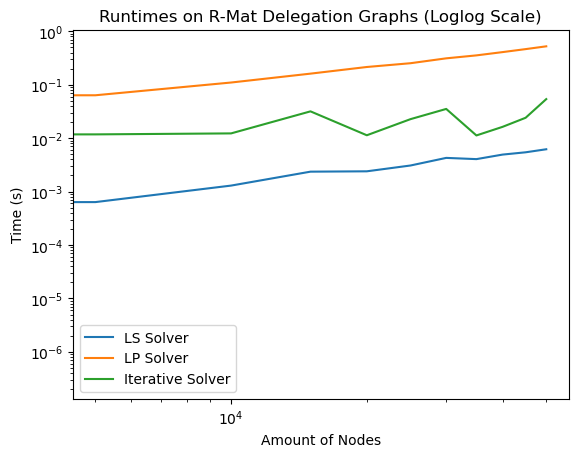

In [5]:
x = list(range_x)

plt.clf()

plt.plot(x, times_le, label=f"LS Solver")
plt.plot(x, times_lp, label=f"LP Solver") 
plt.plot(x, times_iterative, label=f"Iterative Solver")  

plt.legend()
plt.xlabel("Amount of Nodes")
plt.ylabel("Time (s)")
plt.title("Runtimes on R-Mat Delegation Graphs (Loglog Scale)")
plt.loglog()
plt.show()